This notebook serves as an introduction to conducting inference for organ segmentation in human body CT scans. This method holds significant potential across various applications, particularly in radiation therapy, where manual organ segmentation using mathematical tools is standard practice. However, leveraging AI can automate this process, offering more efficient segmentation.

The dataset utilized in this project was sourced from [TCIA (The Cancer Imaging Archive)](https://www.cancerimagingarchive.net/). With gratitude to [Monai (Medical Open Network for Artificial Intelligence)](https://monai.io/), a leading open-source platform, we'll employ a pre-trained model for inference.

The primary aim of this project is twofold: to grasp the computational intensity inherent in medical imaging research and to familiarize ourselves with a suite of Python packages commonly employed in such research endeavors.


In [1]:
import os
import numpy as np
import torch
import pydicom # to view medical images
import matplotlib.pyplot as plt
from tcia_utils import nbia # function to directly download the data from TCIA
from monai.bundle import ConfigParser, download
from monai.transforms import LoadImage, LoadImaged, Orientation, Orientationd, EnsureChannelFirst, EnsureChannelFirstd, Compose
from rt_utils import RTStructBuilder
from scipy.ndimage import label, measurements
import json

In [2]:
data_dir = ".Dilip/organ/data" #to save the data

In [3]:
cart_name = "nbia-56561691129779503" #corresponds to a particular CT image on the archive
cart_data = nbia.getSharedCart(cart_name)
df = nbia.downloadSeries(cart_data, format="df", path = data_dir) #returns a pandas df

2024-05-22 21:43:35,507:INFO:Calling... https://services.cancerimagingarchive.net/nbia-api/services/v1/getContentsByName with parameters {'name': 'nbia-56561691129779503'}
2024-05-22 21:43:36,976:INFO:Downloading 1 Series Instance UIDs (scans).
2024-05-22 21:43:38,284:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.3320.3273.193828570195012288011029757668 already downloaded.
2024-05-22 21:43:38,287:INFO:Downloaded 0 out of 1 Series Instance UIDs (scans).
0 failed to download.
1 previously downloaded.


Every dicom file that is downloaded corresponds to an axial slice of the patient that is a 2-d slice at a constnat Z- axis value

In [4]:
CT_folder = os.path.join(data_dir, '1.3.6.1.4.1.14519.5.2.1.3320.3273.193828570195012288011029757668')

# Pydicom

In [114]:
ds = pydicom.read_file(os.path.join(CT_folder,'1-397.dcm'))
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 206
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.3320.3273.317537027946998850014804237569
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY', 'OTHER']
(0008, 0012) Instance Creation Date              DA: ''
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID      

The provided information constitutes the metadata of the scan, encompassing details from the time the scan was taken to specifics such as the type of X-ray tube used, exposure time, kernel, patient position, and more.

In [60]:
image = ds.pixel_array
image.shape

(512, 512)

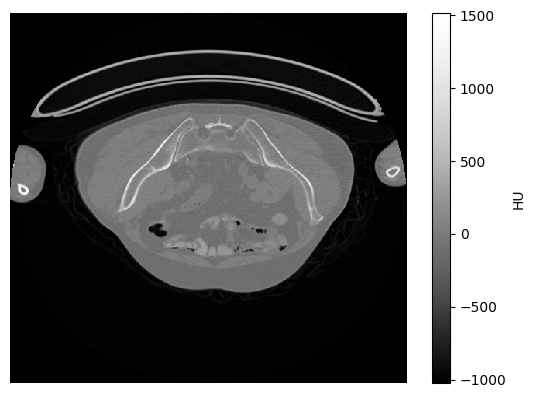

In [61]:
image = ds.RescaleSlope * image + ds.RescaleIntercept
plt.pcolormesh(image, cmap='Greys_r')
plt.colorbar(label='HU')
plt.axis('off')
plt.show()

In medical imaging, "Hounsfield units" (HU) are a measurement used in computed tomography (CT) scanning to quantify the radiodensity of tissues within the body. Water, with a density of 0 HU, serves as the baseline for comparison. Tissues with densities greater than water, such as bone, have positive Hounsfield unit values, while tissues with densities less than water, such as air-filled spaces, have negative values. For instance, bone typically has Hounsfield unit values in the range of +700 to +3000, while air-filled spaces like the lungs have values around -1000.


# monai

In [115]:
image_loader = LoadImage(image_only=True)
CT = image_loader(CT_folder)
CT.meta

{'00200037': {'vr': 'DS', 'Value': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]},
 '00200032': {'vr': 'DS', 'Value': [-249.51171875, -401.01171875, 1937.0]},
 '00280030': {'vr': 'DS', 'Value': [0.9765625, 0.9765625, 2.0]},
 'spacing': array([0.9765625, 0.9765625, 2.       ]),
 'lastImagePositionPatient': array([-249.51171875, -401.01171875,  -11.        ]),
 spatial_shape: (512, 512, 975),
 space: RAS,
 original_affine: array([[-9.76562500e-01,  0.00000000e+00,  0.00000000e+00,
          2.49511719e+02],
        [ 0.00000000e+00, -9.76562500e-01,  0.00000000e+00,
          4.01011719e+02],
        [ 0.00000000e+00,  0.00000000e+00, -2.00000000e+00,
          1.93700000e+03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 affine: tensor([[-9.7656e-01,  0.0000e+00,  0.0000e+00,  2.4951e+02],
         [ 0.0000e+00, -9.7656e-01,  0.0000e+00,  4.0101e+02],
         [ 0.0000e+00,  0.0000e+00, -2.0000e+00,  1.9370e+03],
         [ 0.0000e+00,  0.0000e+00,  0.0000e

The "meta" function in Monai is one of the most valuable tools for medical research, particularly its "affine" and "original affine" attributes. These attributes are particularly useful when dealing with two different medical images that may be in different positions or orientations, enabling researchers to effectively compare them.

In [85]:
CT_coronal_slice = CT[0:,256].cpu().numpy() #look at the middle image in 512 x 512 
CT.shape

torch.Size([512, 512, 975])

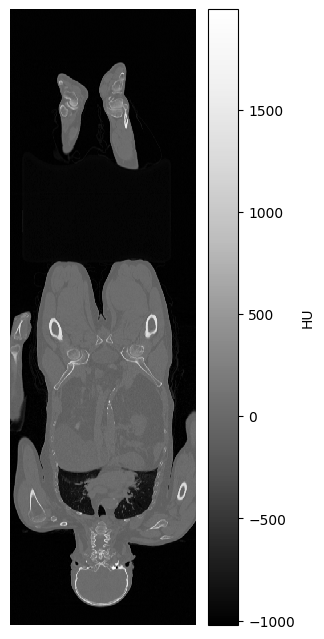

In [86]:
plt.figure(figsize=(3,8))
plt.pcolormesh(CT_coronal_slice.T, cmap='Greys_r')
plt.colorbar(label='HU')
plt.axis('off')
plt.show()

To correct the orientation of an upside-down image, you can apply a transformation. In medical imaging, this often involves manipulating the orientation matrix, which can be done using tools like Monai.

Here's a general approach to applying a transformation to correct the orientation of an image using Monai:

In [87]:
channel_transform = EnsureChannelFirst()
CT = channel_transform(CT)
CT.shape

torch.Size([1, 512, 512, 975])

In [89]:
orientation_transform = Orientation(axcodes=('LPS')) #here, L is left, P = posterior, S - Superior. 
CT = orientation_transform(CT)

In [90]:
CT_coronal_slice = CT[0,:,256].cpu().numpy() #the indexing is [ channel dimension, the row values, and the colonal slice] and convert to numpy

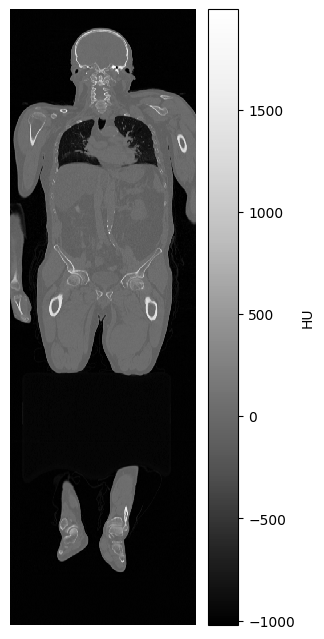

In [91]:
CT_coronal_slice = CT[0,:,256].cpu().numpy()
plt.figure(figsize=(3,8))
plt.pcolormesh(CT_coronal_slice.T, cmap='Greys_r')
plt.colorbar(label='HU')
plt.axis('off')
plt.show()

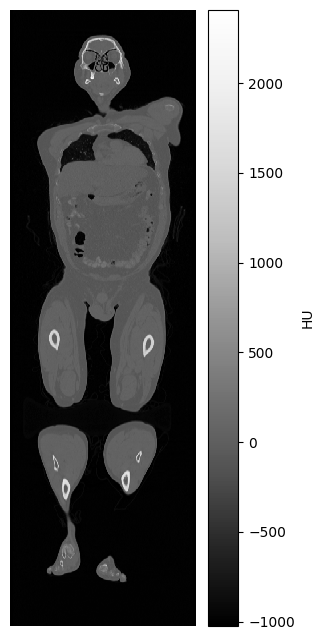

In [92]:
CT_coronal_slice = CT[0,:,196].cpu().numpy()
plt.figure(figsize=(3,8))
plt.pcolormesh(CT_coronal_slice.T, cmap='Greys_r')
plt.colorbar(label='HU')
plt.axis('off')
plt.show()

A notable feature of Monai is its ability to combine various transformations using the "Compose" function, akin to scikit-learn's "Pipeline" class.

In [20]:
#pre-processing pieline before feeding into the AI model
preprocessing_pipeline = Compose([
    LoadImage(image_only=True), #load the image
    EnsureChannelFirst(),#add channel dimenstion
    Orientation(axcodes='LPS')#proper orientation
])


In [ ]:
CT = preprocessing_pipeline(CT_folder)
CT = CT.cuda()
CT_coronal_slice = CT[0, :, 256].cpu().numpy()
data = preprocessing_pipeline(data)

To access the segmentation model, you can download it from the Monai Model Zoo website, which offers open-source models for various medical image operations. Specifically, I'll be utilizing the "wholebody ct segmentation" model for our use case. This model is capable of segmenting approximately 104 segments within the human body.

https://monai.io/model-zoo.html
https://docs.monai.io/en/latest/bundle_intro.html

Monai Bundle Directory:
ModelName
┣━ LICENSE
┣━ configs
┃  ┗━ metadata.json
┣━ models
┃  ┣━ model.pt
┃  ┣━ *model.ts
┃  ┗━ *model.onnx
┗━ docs
   ┣━ *README.md
   ┗━ *license.txt


In [116]:
modeldir = "./model"
model_path = os.path.join(modeldir, 'wholeBody_ct_segmentation', 'models', 'model_lowres.pt')
config_path = os.path.join(modeldir, 'wholeBody_ct_segmentation', 'configs', 'inference.json')

In [94]:
config = ConfigParser()
config.read_config(config_path)

in the config, there are two main impoportant json file that gives you information about the model.
1. metadata.json : Has plethora of information such as what class number belongs to which organ, for instance:
"channel_def": 
                    "0": "background",
                    "1": "spleen",
                    "2": "kidney_right",
                    "3": "kidney_left",
                    "4": "gallbladder",
                    "5": "liver" etc
2. inference.json : This has information such as the device you will use the run the inference on (GPU, CPU), high or low resolution etc.

I'll be making the following changes in the coniguration file to make sure we can run the inference on our laptop as the task at hand is very very very computationally expensive.
a. Change highres to false to use lowres model as follows:
 "displayable_configs": 
        "highres": {false},
        "sw_overlap": 0.25,
        "sw_batch_size": 1

In [95]:
preprocessing = config.get_parsed_content("preprocessing")
data = preprocessing({'image': CT_folder})
model = config.get_parsed_content("network")

In [97]:
#we will load model_lowres.pt which has the trained weights
model.load_state_dict(torch.load(model_path))
model.eval()

SegResNet(
  (act_mod): ReLU(inplace=True)
  (convInit): Convolution(
    (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  )
  (down_layers): ModuleList(
    (0): Sequential(
      (0): Identity()
      (1): ResBlock(
        (norm1): GroupNorm(8, 32, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 32, eps=1e-05, affine=True)
        (act): ReLU(inplace=True)
        (conv1): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
        (conv2): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
      )
    )
    (1): Sequential(
      (0): Convolution(
        (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      )
      (1): ResBlock(
        (norm1): GroupNorm(8, 64, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 64, eps=1e-05, a

The "inferer" pipeline takes in the data and the model, and returns model output. It contains some extra processing steps (in this case it breaks the data into 96x96x96 chunks before feeding it into the model)

In [101]:
inferer = config.get_parsed_content("inferer")

In [102]:
postprocessing = config.get_parsed_content("postprocessing")
data['image'].unsqueeze(0).shape #unsqueeze to make sure it has both channel and batch dimension

torch.Size([1, 1, 167, 167, 650])

In [109]:
input_image = data['image']
device = torch.device("cuda")
input_image = input_image.to(device)

Unfortunately, I couldnt run the inference using the below code even after playing around with batch sizes as I kept facing "memory error".

In [113]:
data = preprocessing({'image': CT_folder}) # returns a dictionary
# 2. Compute mask prediction, add it to dictionary
with torch.no_grad():
    # Have to add additional batch dimension to feed into model
    data['pred'] = inferer(data['image'].unsqueeze(0), network=model)
# Remove batch dimension in image and prediction
data['pred'] = data['pred'][0]
data['image'] = data['image'][0]
# Apply postprocessing to data
data = postprocessing(data)
segmentation = torch.flip(data['pred'][0], dims=[2])
segmentation = segmentation.cpu().numpy()

A typical inference would like like the below image:

![Image Description](output.PNG)

The mask predicted can be used for many purposes

1. Radiotherapy planning to avoid certain organs

2. Compute organ volumes, eg: Computing bladder volume

In [117]:
number_bladder_voxels = (segmentation==13).sum().item() #count the number of voxels (3d pixel) in the predicted segmentation mask
voxel_volume_cm3 = np.prod(CT.meta['spacing']/10) #volume of a single voxel in cubic centimetre using monai's meta
bladder_volume = number_bladder_voxels * voxel_volume_cm3 #number of bladder voxels X volume of every voxel
print(f'Bladder Volume {bladder_volume:.1f}cm^3')

Bladder Volume 865.7cm^3